自制实现的LSTM训练结果:
epoch: 100, 对'time traveller'的预测:time traveller the the the the the the the the the the the the t
epoch: 200, 对'time traveller'的预测:time traveller the thee the thee the thee the thee the thee the 
epoch: 300, 对'time traveller'的预测:time traveller that the gron this the time travel dime travel do
epoch: 400, 对'time traveller'的预测:time travellerit would be reall tho kidined man a oubre which lo
epoch: 500, 对'time traveller'的预测:time traveller wht gou hindling thive at t a ciniliesthat he sre
困惑度1.15, 25222.4词元/秒 在cuda:0上
对prefix为'time traveller'的预测:time traveller wht gou hindling thive at t a ciniliesthat he sre
对prefix为'traveller'的预测:traveller found about but now of the wrong side of that ide


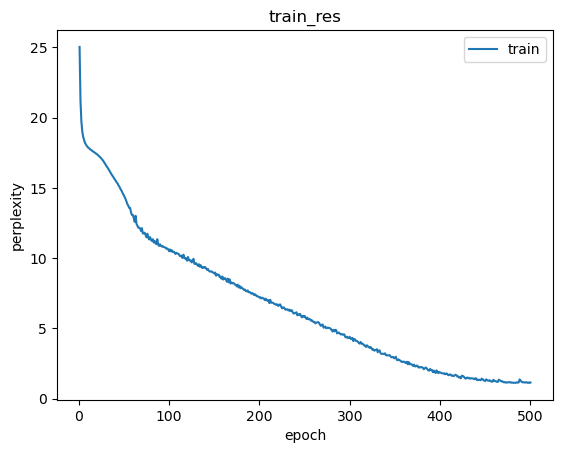

PytorchAPI的LSTM训练结果:
epoch: 100, 对'time traveller'的预测:time traveller the the the the the the the the the the the the t
epoch: 200, 对'time traveller'的预测:time traveller the time traveller the time traveller the time tr
epoch: 300, 对'time traveller'的预测:time traveller a soment onccening and thatting hay onllong thase
epoch: 400, 对'time traveller'的预测:time traveller for so it will be convenien to she wack the cime 
epoch: 500, 对'time traveller'的预测:time traveller for so it will be convenient to speak of himwas e
困惑度1.04, 269085.1词元/秒 在cuda:0上
对prefix为'time traveller'的预测:time traveller for so it will be convenient to speak of himwas e
对prefix为'traveller'的预测:travelleryou can show black is white by argument said filby


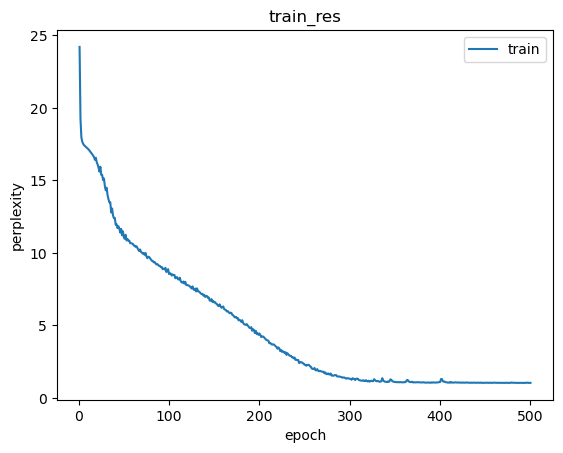

In [5]:
import torch, utils
from torch import nn

"""
LSTM:长短期记忆网络
1.长短期记忆网络有三种类型的门：输入门、遗忘门和输出门。
2.长短期记忆网络的隐藏层输出包括隐状态和记忆元。只有隐状态会传递到输出层，而记忆元完全属于内部信息。
3.长短期记忆网络可以缓解梯度消失和梯度爆炸。
"""

# 从零实现
def init_params_lstm(vocab_size, num_hiddens, device):
    """初始化LSTM的参数列表"""
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    def three():
        """返回一个三元组(输入->门的权重参数, 隐藏->门的权重参数, 门的偏置参数)"""
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))
    
    num_inputs = num_outputs = vocab_size
    W_xi, W_hi, b_i = three() # 输入门的参数
    W_xf, W_hf, b_f = three() # 遗忘门的参数
    W_xo, W_ho, b_o = three() # 输出门的参数
    W_xc, W_hc, b_c = three() # 候选记忆元参数
    W_hq, b_q = normal((num_hiddens, num_outputs)), torch.zeros(num_outputs, device=device) # 输出层参数
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, 
              W_xo, W_ho, b_o, W_xc, W_hc, b_c,  W_hq, b_q]
    for param in params: # 附加梯度
        param.requires_grad_(True)
    return params

def init_state_lstm(batch_size, num_hiddens, device):
    """
    与GRU不同的是,LSTM的隐状态初始化需要返回一个额外的记忆元
    注意只有隐状态参与输出计算,记忆元C_t不直接参与输出计算而是参与隐状态计算
    """
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

def lstm_forward(inputs, state, params):
    """返回输出预测和隐状态元组(隐状态H, 记忆元C)"""
    W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q = params
    (H, C) = state
    outputs = []
    for X in inputs: # 迭代时间步
        I = torch.sigmoid(X@W_xi + H@W_hi + b_i) # 更新输出门
        F = torch.sigmoid(X@W_xf + H@W_hf + b_f) # 更新遗忘门
        O = torch.sigmoid(X@W_xo + H@W_ho + b_o) # 更新输出门
        C_tilde = torch.tanh(X@W_xc + H@W_hc + b_c) # 更新候选记忆元
        C = F*C + I*C_tilde # 更新记忆元
        H = O * torch.tanh(C) # 更新隐状态
        Y = H@W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,C)

batch_size, num_steps = 32, 35
num_epochs, lr = 500, 1
train_iter, vocab = utils.load_time_machine_data(batch_size, num_steps)
vocab_size, num_hiddens, device = len(vocab), 256, utils.try_gpu()
net = utils.RNNScratch(vocab_size, num_hiddens, init_params_lstm, lstm_forward, init_state_lstm, device)

print("自制实现的LSTM训练结果:")
utils.rnn_train(net, train_iter, vocab, lr, num_epochs, device)

# 使用PytorchAPI实现
num_inputs = vocab_size
net = utils.RNN(nn.LSTM(num_inputs, num_hiddens), vocab_size).to(device)

print("PytorchAPI的LSTM训练结果:")
utils.rnn_train(net, train_iter, vocab, lr, num_epochs, device)

#### 一、LSTM中更新各个门的公式
其中$I_t$为输入门, $F_t$为遗忘门, $O_t$为输出门
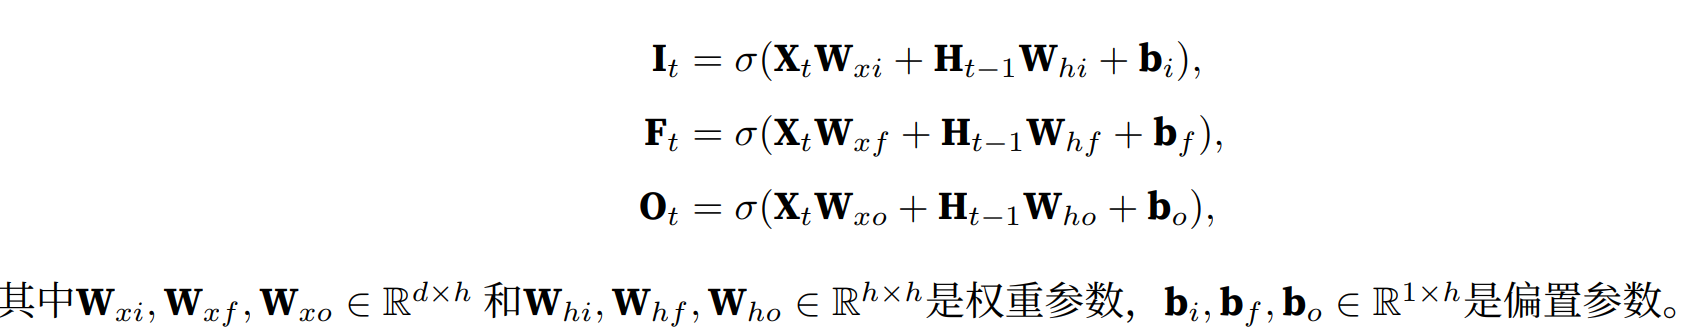
#### 二、计算候选记忆元的公式
候选记忆元为$\tilde{C_t}$, 由于$tanh$激活函数的作用,取值为(-1,1)
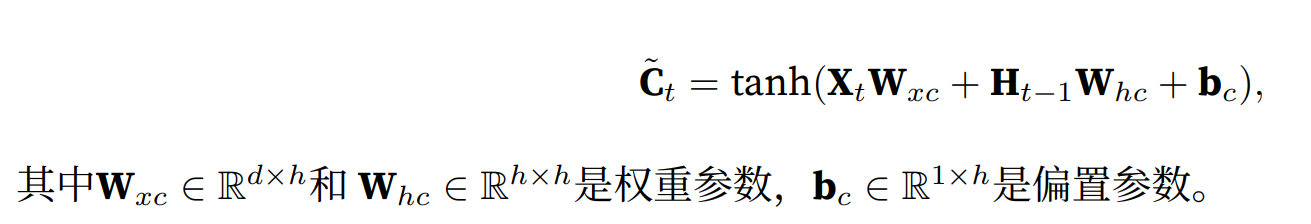
#### 三、更新记忆元的公式
记忆元为$C_t$
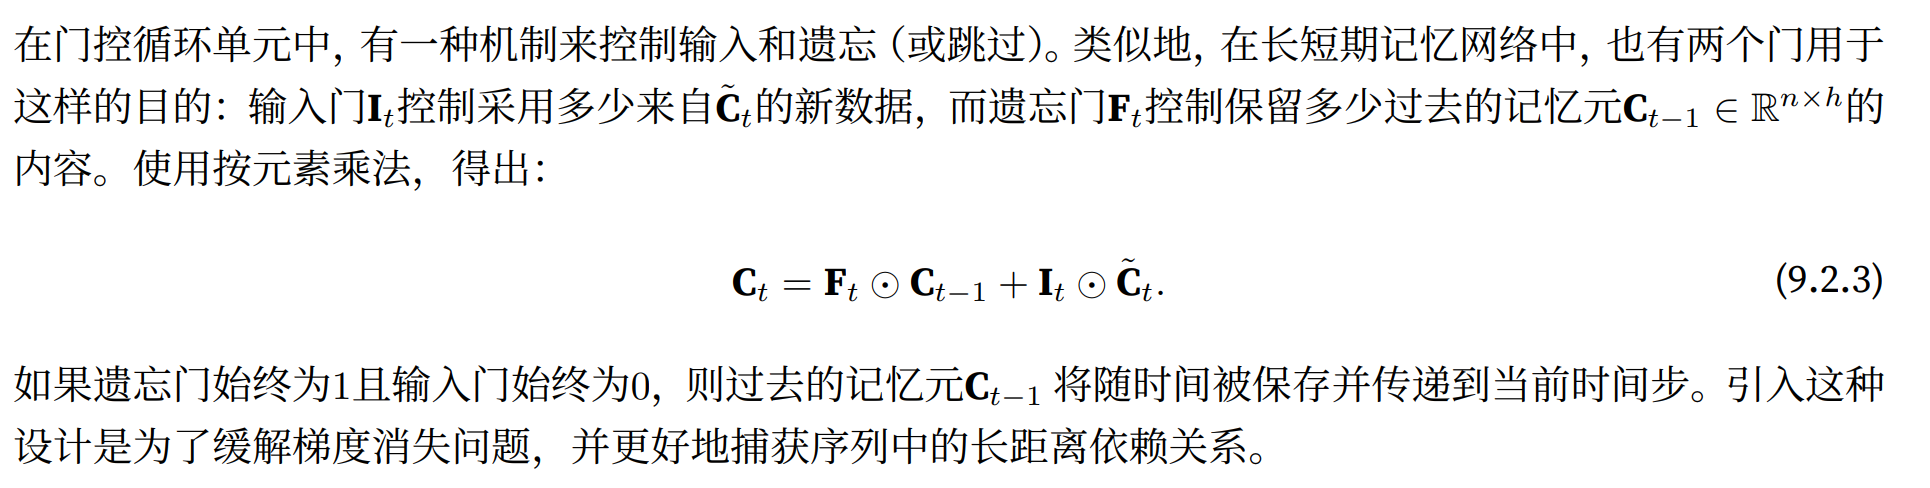
#### 四、计算隐状态
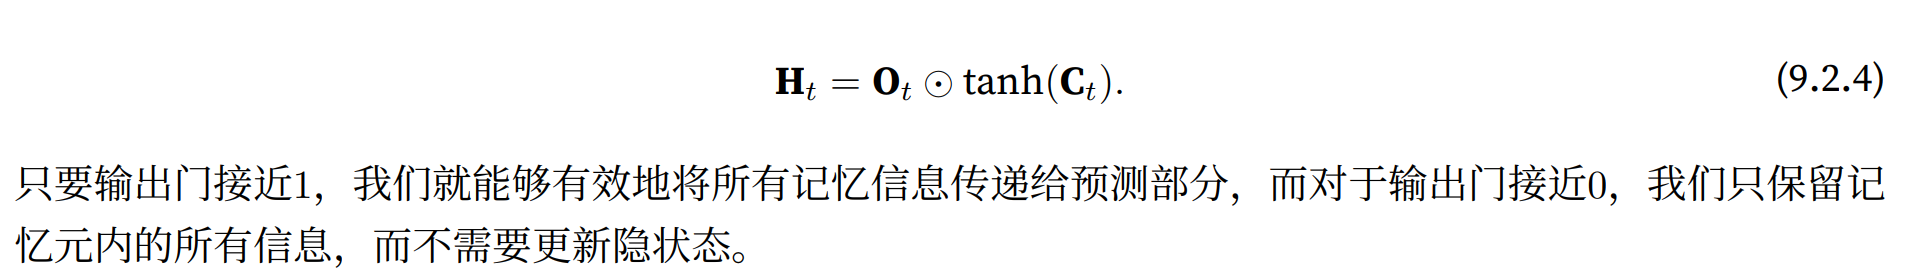
#### 五、LSTM的隐状态更新图
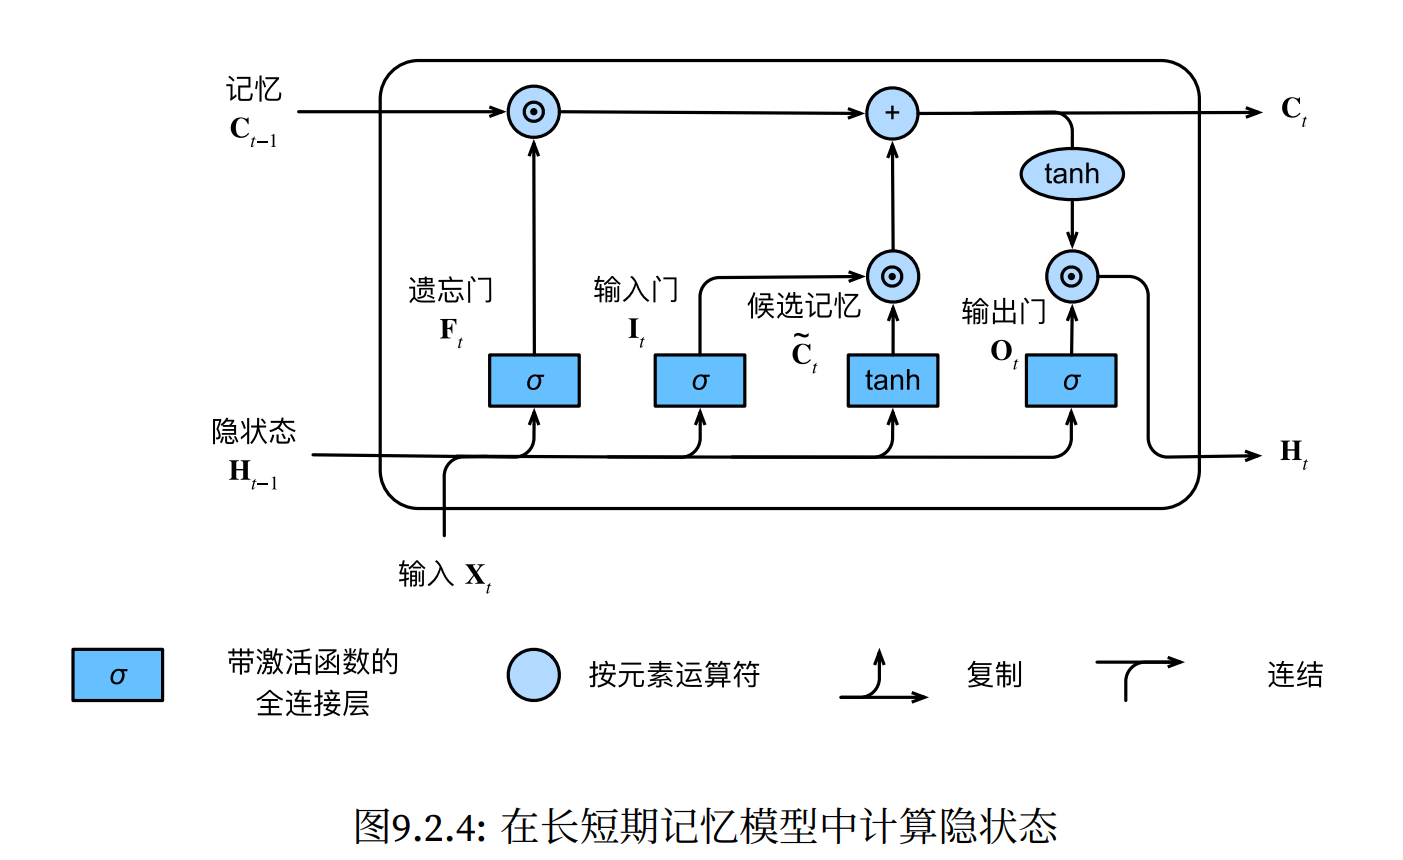